# <center> Logistic Regression in TensorFlow </center>
![title](logistic.gif)

# Introduction
In this section, we are going to implement Logistic Regression using Tensorflow. We have scraped images of various products from a leading retail website. Images are arranged in a folder structure where the name of the folder designates what kind of product is the image. We are going to train a model in order to classify whether an image is of a 'chair-recliners' or not. For ease, we are going to train the model using only 'FURNITURE' data.

<img src="Data Structure.PNG">

In [1]:
# Importing required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Helper libraries to locate and read images
from glob import glob
import cv2
import os
import time

%matplotlib inline

# Setting seed
np.random.seed(100)

## Helper Functions to read data

In [2]:
def get_im_cv2(path,size):
    img = cv2.imread(path)
    img = cv2.resize(img, (size, size))
    return img

def load_data():
    X_train = []
    y_train = []
    X_train_show = []
    start_time = time.time()

    print('Read train images')
    root = glob(".\\Data/*/*") 
    for fld in range(len(root)):
        index = root[fld].split('\\')[3]
        print('Load folder '+index)
        files = glob(root[fld]+"/*.jpg")
        for i in range(len(files)):
            flbase = os.path.basename(files[i])
            X_train.append(get_im_cv2(files[i],28))
            X_train_show.append(get_im_cv2(files[i],256))
            y_train.append(index)

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return np.array(X_train),np.array(X_train_show), y_train

In [3]:
# Function call to load data
Xall,Xall_show, Yind = load_data()

Read train images
Load folder chairs-recliners
Load folder otherfurniture
Read train data time: 8.74 seconds


## Visualize data

In [4]:
# Sanity check values in Yind
Yind[:5]

['chairs-recliners',
 'chairs-recliners',
 'chairs-recliners',
 'chairs-recliners',
 'chairs-recliners']

y = chairs-recliners, it's a 'chairs-recliners' picture.


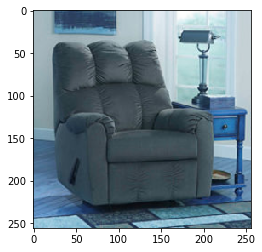

In [5]:
# Example of a picture, change the image number to view each image
index = 1
plt.imshow(Xall_show[index])
print ("y = " + str(Yind[index]) + ", it's a '" + str(Yind[index]) +  "' picture." )

In [6]:
# Create a binary (0,1) indicator from Yind
Yall = np.array([1 if x == 'chairs-recliners' else 0 for x in Yind])

In [7]:
# Check the image sizes
m_train = Xall.shape[0]
num_px = Xall.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("all data X shape: " + str(Xall.shape))
print ("all data Y shape: " + str(Yall.shape))

Number of training examples: m_train = 1779
Height/Width of each image: num_px = 28
all data X shape: (1779, 28, 28, 3)
all data Y shape: (1779,)


#### Note the shape of all data X. Here 1779 resembles the number of images, 28 is the image size and 3 is the number of channels (RGB) for each image. 

## Data Preprocessing
Logistic regression convergence works better when the features are scaled between 0 and 1 (min-max scaling)

In [8]:
Xall = Xall/255.

## Data Split to Train and Test

In [9]:
train_indices = np.random.choice(len(Xall), round(len(Xall)*0.8), replace=False)
test_indices = np.array(list(set(range(len(Xall))) - set(train_indices)))
x_vals_train = Xall[train_indices]
x_vals_test = Xall[test_indices]
Y_train = Yall[train_indices]
Y_test = Yall[test_indices]

## Flatten the data
Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px  ∗  num_px  ∗ 3, 1).

In [10]:
X_train = x_vals_train.reshape(x_vals_train.shape[0], -1) 
X_test = x_vals_test.reshape(x_vals_test.shape[0], -1)

In [11]:
print ("train_set_x_flatten shape: " + str(X_train.shape))
print ("y_vals_train shape: " + str(Y_train.shape))
print ("test_set_x_flatten shape: " + str(X_test.shape))
print ("y_vals_test shape: " + str(Y_test.shape))

train_set_x_flatten shape: (1423, 2352)
y_vals_train shape: (1423,)
test_set_x_flatten shape: (356, 2352)
y_vals_test shape: (356,)


## Logistic Regression
**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
    - The weights are initialized with random values at the beginning of the training.
    - For each element of the training set is calculated the error, that is, the difference between the desired output and the actual output. This error is used to adjust the weights 
    - The process is repeated resubmitting to the network, in a random order, all the examples of the training set until the error made on the entire training set is not less than a certain threshold or until the number of iterations are over.
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

In [105]:
# Resetting Tensorboard
tf.reset_default_graph()

# Defining parameters
learning_rate = 0.001
training_epochs = 100
batch_size = 1500
nobs = X_train.shape[0]
num_features = X_train.shape[1]

# create placeholders for input X (features defining an image) and output Y (chair-recliner or not)
with tf.name_scope("Defining_Placholders_Variables"):
    X = tf.placeholder(tf.float32, [None, num_features],name='Input')
    Y = tf.placeholder(tf.float32, [None,1],'Actual_Output')
    W = tf.Variable(tf.zeros(shape=[num_features,1]), name='Weights') # create a tensorflow variable which will contain weights 
    b = tf.Variable(tf.zeros(shape=[1,1]), name='Bias')
    
# initialize the necessary variables, in this case, W and b
init = tf.global_variables_initializer()

In [106]:
with tf.name_scope('Prediction_using_activation'):
    y_ = tf.sigmoid(tf.add(tf.matmul(X,W),b)) # construct model to predict y_ sigmoid(W.T * X + b)

# Add summary ops to collect data
w_h = tf.summary.histogram("Weights", W)
b_h = tf.summary.histogram("Bias", b)
    
with tf.name_scope('Loss_Calculation'):
    cost = tf.reduce_mean(tf.reduce_sum((-Y * tf.log(y_)) - ((1 - Y) * tf.log(1 - y_)), reduction_indices=[1]), name="Loss") # defining cost
    # Create a summary to monitor the cost function
    tf.summary.scalar("cost_function", cost)
    
with tf.name_scope('Gradient_Descent_Optimization'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost) # using gradient descent with learning rate (defined above) to minimize loss

with tf.name_scope('Accuracy_Calculation'):
    prediction = tf.round(y_) # calculate accuracy
    predictions_correct = tf.cast(tf.equal(prediction, Y), tf.float32)
    accuracy = tf.reduce_mean(predictions_correct)

In [107]:
loss_vec = []
train_acc = []
test_acc = []

# Merge all summaries into a single operator
merged_summary_op = tf.summary.merge_all()


# train the model
with tf.Session() as sess:
    sess.run(init)

    for i in range(training_epochs):
        rand_index = np.random.choice(len(X_train), size=batch_size)
        rand_x = X_train[rand_index]
        rand_y = np.transpose([Y_train[rand_index]])
        
        writer = tf.summary.FileWriter("path/to/logs/directory", sess.graph)
        sess.run([optimizer, cost], feed_dict={X: rand_x, Y: rand_y})
        
        # Write logs for each iteration
        summary_str = sess.run(merged_summary_op, feed_dict={X: rand_x, Y: rand_y})
        writer.add_summary(summary_str, i)
        
        
        temp_loss = sess.run([optimizer, cost], feed_dict={X: rand_x, Y: rand_y})
        loss_vec.append(temp_loss)
        

        temp_acc_train = sess.run(accuracy, feed_dict={X: X_train, Y: np.transpose([Y_train])})
        train_acc.append(temp_acc_train)
        
        temp_acc_test = sess.run(accuracy, feed_dict={X: X_test, Y: np.transpose([Y_test])})
        test_acc.append(temp_acc_test)
        
        if i % 20 == 0:
            msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Loss: {3:.3f}"
            print(msg.format(i, temp_acc_train, temp_acc_test, temp_loss[1]))
            
    temp_acc_train = sess.run(accuracy, feed_dict={X: X_train, Y: np.transpose([Y_train])})
    temp_acc_test = sess.run(accuracy, feed_dict={X: X_test, Y: np.transpose([Y_test])})
    msg = "Training Accuracy: {0:>6.1%}, Validation Accuracy: {1:>6.1%}"
    print(msg.format(temp_acc_train, temp_acc_test))

Epoch 0 --- Training Accuracy:  58.3%, Validation Accuracy:  59.3%, Loss: 0.684
Epoch 20 --- Training Accuracy:  70.1%, Validation Accuracy:  71.1%, Loss: 0.607
Epoch 40 --- Training Accuracy:  76.5%, Validation Accuracy:  76.1%, Loss: 0.567
Epoch 60 --- Training Accuracy:  78.5%, Validation Accuracy:  77.2%, Loss: 0.541
Epoch 80 --- Training Accuracy:  80.5%, Validation Accuracy:  77.2%, Loss: 0.511
Training Accuracy:  81.0%, Validation Accuracy:  77.5%


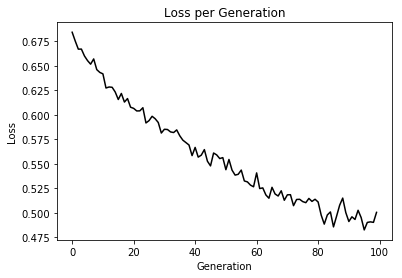

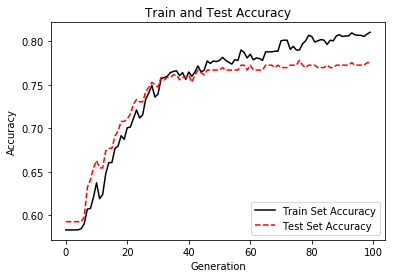

In [108]:
# Plot the loss over the iterations and train and test set accuracies.
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Thankyou!